# Import Libraries

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np

# Dataset loading and preprocessing

In [29]:
transform = transforms.Compose([transforms.ToTensor()]) # convert images to tensor

# download and install training and test dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# batch size
batch_size = 128

# eğitim ve test veri yükleyicileri oluşturma
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# autoencoders development

In [30]:
class AutoEncoder(nn.Module):

    def __init__(self):
        super(AutoEncoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(), # 28x28 -> 784 vektor
            nn.Linear(28 * 28, 256), # 784 -> 128 # fc layer
            nn.ReLU(), # activation function
            nn.Linear(256, 64), # 256 -> 64
            nn.ReLU()
            )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(64, 256), # 64 -> 256 fc layer
            nn.ReLU(), # activation function
            nn.Linear(256, 28 * 28), # 128 -> 784 # fc layer
            nn.Sigmoid(), # sigmoid is used to keep it in the range 0-1
            nn.Unflatten(1, (1, 28, 28)) # 784 -> 28x28
            )

    def forward(self, x):

        encoded = self.encoder(x) # encodes input data
        decoded = self.decoder(encoded) # converts the encoded data back into an image
        return decoded

# model = AutoEncoder()

# callback: early stopping

In [31]:
class EarlyStopping: # early stopping (belonging to the callback class)

    def __init__(self, patience=3, min_delta=0.001):
        self.patience = patience # parameter that specifies how many epochs we will stop if there is no progress
        self.min_delta = min_delta # minimum amount of recovery from loss
        self.best_loss = None # best loss value
        self.counter = 0 # epoch counter remaining constant

    def __call__(self, loss):

        if self.best_loss is None or loss < self.best_loss - self.min_delta: # there is improvement
            self.best_loss = loss
            self.counter = 0 # reset the counter if there is any improvement
        else: # If there is no improvement, the counter is increased.
            self.counter += 1

        if self.counter >= self.patience: # If the remaining epoch count exceeds patience -> stop
                return True # stop training

        return False

# model training

In [32]:
# Hyperparameters
epochs = 50 # number of training repetitions
learning_rate = 1e-3

# Let's define the model, loss and optimizer
model = AutoEncoder() # define model
criterion = nn.MSELoss() # loss function -> mse: mean square error
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # optimizer
early_stopping = EarlyStopping(patience=5, min_delta = 0.001) # early stopping object

# training function
def training(model, train_loader, optimizer, criterion, early_stoppin, epochs):
  model.train() # put the model in training mode
  for epoch in range(epochs):
      total_loss = 0 # total loss per epoch
      for inputs, _ in train_loader:
          optimizer.zero_grad() # set gradients equal to zero
          outputs = model(inputs) # output the model
          loss = criterion(outputs, inputs) # loss between actual and estimated data
          loss.backward() # calculate gradients
          optimizer.step() # update weights
          total_loss += loss.item() # total loss value for each epoch

      avg_loss = total_loss / len(train_loader) # average loss per epoch
      print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.5f}")

      # early stopping
      if early_stopping(avg_loss): #  if early stopping conditions are met
          print(f"Early stopping at epoch {epoch+1}")
          break

training(model, train_loader, optimizer, criterion, early_stopping, epochs)




Epoch 1/50, Loss: 0.03354
Epoch 2/50, Loss: 0.01723
Epoch 3/50, Loss: 0.01455
Epoch 4/50, Loss: 0.01315
Epoch 5/50, Loss: 0.01227
Epoch 6/50, Loss: 0.01154
Epoch 7/50, Loss: 0.01099
Epoch 8/50, Loss: 0.01057
Epoch 9/50, Loss: 0.01023
Epoch 10/50, Loss: 0.00990
Epoch 11/50, Loss: 0.00965
Epoch 12/50, Loss: 0.00945
Epoch 13/50, Loss: 0.00927
Epoch 14/50, Loss: 0.00912
Epoch 15/50, Loss: 0.00900
Epoch 16/50, Loss: 0.00890
Epoch 17/50, Loss: 0.00880
Epoch 18/50, Loss: 0.00871
Epoch 19/50, Loss: 0.00864
Early stopping at epoch 19


# model testing

Average SSIM score: 0.9998087686125215


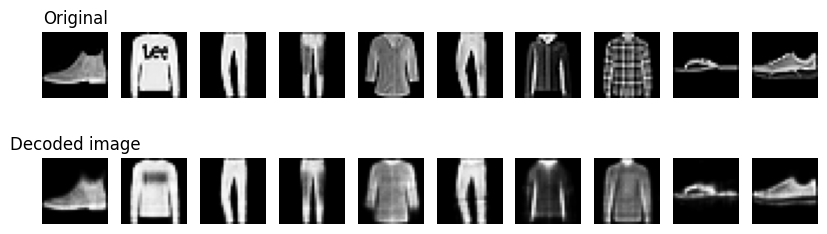

In [33]:
from scipy.ndimage import gaussian_filter

def compute_ssim(img1, img2, sigma = 1.5):

    # calculates the similarity between two images
    C1 = (0.01 * 255)**2 # One of the ssim constants
    C2 = (0.03 * 255)**2 # other constant

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)

    # averages of images
    mu1 = gaussian_filter(img1, sigma)
    mu2 = gaussian_filter(img2, sigma)

    mu1_sq = mu1**2 # We took the square root of the first image
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2

    sigma1_sq = gaussian_filter(img1**2, sigma) - mu1_sq # we took the variance of the first image
    sigma2_sq = gaussian_filter(img2**2, sigma) - mu2_sq
    sigma12 = gaussian_filter(img1 * img2, sigma) - mu1_mu2 # we took the covariance of the two images

    # ssim map calculation
    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    return ssim_map.mean() # return average ssim score

def evaluate(model, test_loader, n_images = 10):

    model.eval() # put the model in evaluation mode

    with torch.no_grad(): # disable calculation of gradients
        for batch in test_loader:
            inputs, _ = batch
            outputs = model(inputs) # we produce the outputs of the model
            break

    inputs = inputs.numpy() # convert to numpy array
    outputs = outputs.numpy()

    fig, axes = plt.subplots(2, n_images, figsize = (n_images,3)) # subplot for visualization
    ssim_scores = [] # to store ssim scores

    for i in range(n_images):

        img1 = np.squeeze(inputs[i]) # compress original image
        img2 = np.squeeze(outputs[i]) # compress the generated image

        ssim_score = compute_ssim(img1, img2) # Calculate SSIM score
        ssim_scores.append(ssim_score) # Add Ssim score to the list

        axes[0, i].imshow(img1, cmap = 'gray') # show original image
        axes[0, i].axis('off') # close axes

        axes[1, i].imshow(img2, cmap = 'gray') # show created image
        axes[1, i].axis('off') # close axes

    axes[0,0].set_title("Original")
    axes[1,0].set_title("Decoded image")
    plt.show

    avg_ssim = np.mean(ssim_scores) # average ssim scores
    print(f"Average SSIM score: {avg_ssim}") # print average ssim score

evaluate(model, test_loader, n_images=10)